In [14]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datashader as ds
import datashader.transfer_functions as tf
from datashader.utils import export_image
from datashader.datatypes import RaggedArray

In [16]:
# Optional colormaps
try:
    import colorcet as cc
    DENSITY_CMAP = cc.blues  # nice "cone" look
except Exception:
    DENSITY_CMAP = "Blues"


def load_scalar_trajectories(path: str):
    # header: n nt dt T
    with open(path, "r") as f:
        header = f.readline().strip().split()
    if len(header) < 4:
        raise ValueError(f"Header must have 4 numbers: n nt dt T. Got: {header}")

    n = int(float(header[0]))
    nt = int(float(header[1]))
    dt = float(header[2])
    T = float(header[3])

    data = np.loadtxt(path, skiprows=1, dtype=np.float32)
    if data.shape != (n, nt):
        raise ValueError(f"Shape mismatch: header says ({n},{nt}), file read {data.shape}")

    return {"n": n, "nt": nt, "dt": dt, "T": T}, data


def _ragged_df_from_matrix(data: np.ndarray, dt: float, particle_ids=None):
    """
    Builds a ragged-line DataFrame for datashader Canvas.line(..., axis=1)
    Each row is one polyline.
    """
    n, nt = data.shape
    t = (np.arange(nt, dtype=np.float32) * dt)

    if particle_ids is None:
        particle_ids = np.arange(n, dtype=np.int32)

    # Ragged arrays: one list entry per particle polyline
    time_ragged = RaggedArray([t] * len(particle_ids))
    val_ragged = RaggedArray([data[i, :] for i in particle_ids])

    return pd.DataFrame({"time": time_ragged, "val": val_ragged})


def render_density_plus_overlay(
    data: np.ndarray,
    dt: float,
    out_png="all_trajectories_overlay.png",
    plot_width=1400,
    plot_height=800,
    background="black",
    overlay_n=150,           # how many individual trajectories to draw on top
    overlay_seed=0,
    overlay_alpha=220,       # 0..255 (higher = more visible)
):
    n, nt = data.shape
    t = np.arange(nt, dtype=np.float32) * dt

    x_range = (float(t[0]), float(t[-1]))
    y_range = (float(np.nanmin(data)), float(np.nanmax(data)))

    cvs = ds.Canvas(
        plot_width=plot_width,
        plot_height=plot_height,
        x_range=x_range,
        y_range=y_range,
    )

    # ----- 1) DENSITY: all trajectories -----
    df_all = _ragged_df_from_matrix(data, dt)
    agg_all = cvs.line(df_all, x="time", y="val", agg=ds.count(), axis=1)

    # "eq_hist" gives that nice high-dynamic-range cone look
    img_density = tf.shade(agg_all, cmap=DENSITY_CMAP, how="eq_hist")
    img_density = tf.set_background(img_density, background)

    # ----- 2) OVERLAY: a few individual trajectories as thin cyan lines -----
    rng = np.random.default_rng(overlay_seed)
    overlay_n = min(overlay_n, n)
    overlay_ids = rng.choice(n, size=overlay_n, replace=False).astype(np.int32)

    df_overlay = _ragged_df_from_matrix(data, dt, particle_ids=overlay_ids)
    agg_overlay = cvs.line(df_overlay, x="time", y="val", agg=ds.count(), axis=1)

    # Single-color overlay (light-cyan)
    # (Datashader expects hex; alpha handled via dynspread/spread + stacking)
    img_overlay = tf.shade(agg_overlay, cmap=["#AEEBFF"], how="linear")
    img_overlay = tf.set_background(img_overlay, background)

    # Make overlay lines a bit thicker/clearer (optional)
    img_overlay = tf.dynspread(img_overlay, threshold=0.5, max_px=2)

    # Combine: overlay on top of density
    # We control overlay visibility with alpha by post-multiplying RGBA
    # (simple way: use stack and keep overlay light)
    img = tf.stack(img_density, img_overlay)

    export_image(img, out_png.replace(".png", ""), fmt=".png")
    return img


if __name__ == "__main__":
    path = r"C:\Users\Kaavy\OneDrive\Documents\CL677\particles.txt"    # SAMANTH CHANGE THIS

    meta, data = load_scalar_trajectories(path)
    print("Loaded:", meta, "data shape:", data.shape)

    render_density_plus_overlay(
        data,
        dt=meta["dt"],
        out_png="all_trajectories_overlay.png",
        plot_width=1600,
        plot_height=900,
        overlay_n=200,     
        overlay_seed=1,
    )
    print("Wrote all_trajectories_overlay.png")

Loaded: {'n': 10000, 'nt': 2500, 'dt': 0.04, 'T': 100.0} data shape: (10000, 2500)
Wrote all_trajectories_overlay.png


In [20]:
def show_with_time_axis(img, t_min, t_max, y_min, y_max, xlabel="Time", ylabel="Value",):
    fig, ax = plt.subplots(figsize=(10, 5), dpi=150)
   
    ax.imshow(
        img.to_pil(),
        extent=[t_min, t_max, y_min, y_max],
        origin="lower",
        aspect="auto",
    )
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.tick_params(colors="white")
    for spine in ax.spines.values():
        spine.set_color("white")
    ax.set_facecolor("black")
    fig.patch.set_facecolor("black")

    plt.tight_layout()
    plt.show()

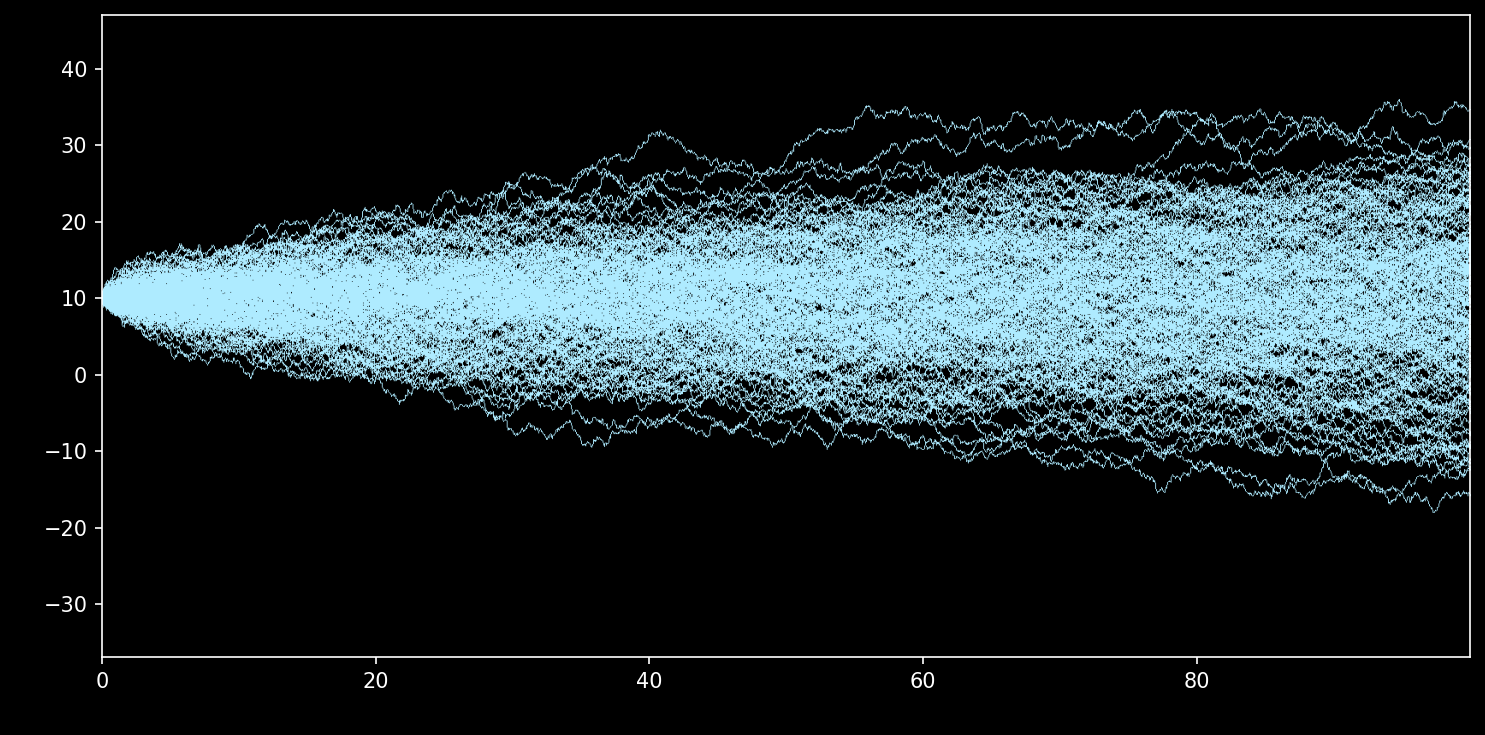

In [22]:
t_min = 0.0
t_max = meta["dt"] * (meta["nt"] - 1)
y_min = np.min(data)
y_max = np.max(data)
img = render_density_plus_overlay(
    data,
    dt=meta["dt"],
    out_png="all_trajectories_overlay.png",
    plot_width=1600,
    plot_height=900,
    overlay_n=200,
    overlay_seed=1,
)

show_with_time_axis(
    img,
    t_min=t_min,
    t_max=t_max,
    y_min=y_min,
    y_max=y_max,
    xlabel="Time",
    ylabel="Particle value",
)

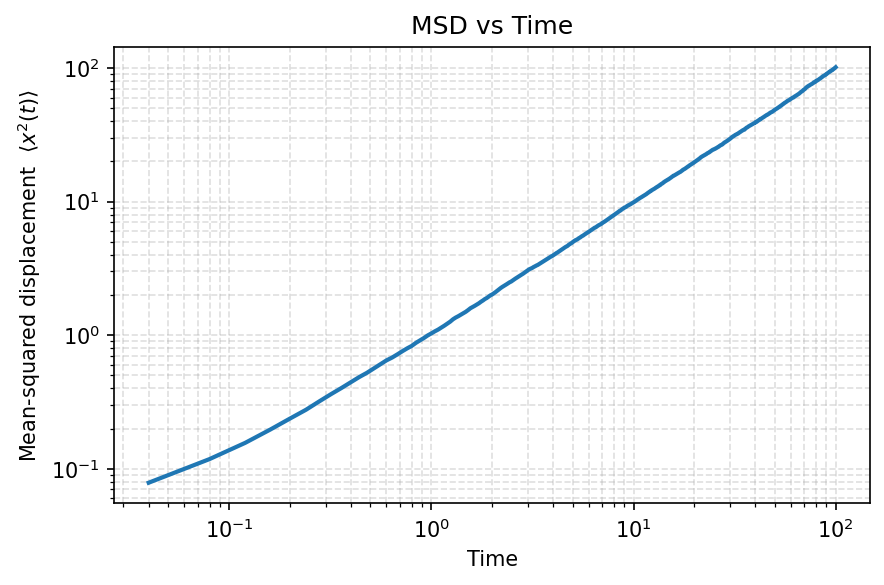

In [26]:
# compute MSD
msd = np.mean(data**2, axis=0)

# time array
t = np.arange(meta["nt"]) * meta["dt"]

# log-log plot
plt.figure(figsize=(6, 4), dpi=150)

# skip t=0 to avoid log(0)
plt.loglog(t[1:], msd[1:], lw=2)

plt.xlabel("Time")
plt.ylabel(r"Mean-squared displacement  $\langle x^2(t) \rangle$")
plt.title("MSD vs Time")

plt.grid(True, which="both", ls="--", alpha=0.4)
plt.tight_layout()
plt.show()

In [28]:
# choose fitting window
i0 = 10                 # skip very early times (avoid log(0), transients)
i1 = len(t) // 2        # avoid late-time finite-size effects
log_t = np.log(t[i0:i1])
log_msd = np.log(msd[i0:i1])
alpha, intercept = np.polyfit(log_t, log_msd, 1)
print("Estimated scaling exponent α =", alpha)

Estimated scaling exponent α = 0.9880660880596969
